In [2]:
# Setup Spark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, count, isnan,
    hour, dayofweek, month, year,
    lag
)
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DoubleType

spark = SparkSession.builder \
    .appName("Praktikum_BigData_Flight") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

In [6]:
df = spark.read.csv(
    "file:///home/zurich/Downloads/flight data.csv",
    header=True,
    inferSchema=True
)


In [9]:
# CLEANING DATA
df = df.dropDuplicates()
df = df.dropna(how="all")
df = df.fillna({
    "price": 0,
    "stops": 0
})
if "duration" in df.columns:
    median_duration = df.approxQuantile("duration", [0.5], 0.05)[0]
    df = df.fillna({"duration": median_duration})
print("Baris & Kolom:", df.count(), len(df.columns))

[Stage 29:===================>                                      (2 + 4) / 6]

Baris & Kolom: 947669 18


In [13]:
#Mengecek Jumlah Baris, Memahami Dataset
print("=== EDA ===")
print("\n--- Missing Value per Kolom ---")
df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show(truncate=False)
print("\n--- Statistik Fitur Numeric ---")
df.select("price", "duration", "stops").describe().show(truncate=False)
print("\n--- Korelasi ---")
print("Correlation price-duration:", df.stat.corr("price", "duration"))
print("\n--- Rata-rata Harga per Maskapai (Top 5) ---")
df.groupBy("airline_name") \
  .agg(F.avg("price").alias("avg_price")) \
  .orderBy(F.desc("avg_price")) \
  .show(5, truncate=False)

=== EDA ===

--- Missing Value per Kolom ---


+-----------------+------------+-----------------+------------+-------------+--------------+------------+-------------+--------------+------------+--------+-----+-----+--------+-------------+-------------------------------+--------------+---------+--------+---------+
|from_airport_code|from_country|dest_airport_code|dest_country|aircraft_type|airline_number|airline_name|flight_number|departure_time|arrival_time|duration|stops|price|currency|co2_emissions|avg_co2_emission_for_this_route|co2_percentage|scan_date|dep_hour|dep_month|
+-----------------+------------+-----------------+------------+-------------+--------------+------------+-------------+--------------+------------+--------+-----+-----+--------+-------------+-------------------------------+--------------+---------+--------+---------+
|0                |0           |0                |0           |13885        |0             |0           |0            |0             |0           |0       |0    |0    |0       |4671         |82563

+-------+------------------+------------------+------------------+
|summary|price             |duration          |stops             |
+-------+------------------+------------------+------------------+
|count  |947669            |947669            |947669            |
|mean   |1736.9656272390466|1448.5734576101993|1.6254462264778102|
|stddev |1970.1550187983446|702.0606893280803 |0.6495910007925044|
|min    |0.0               |55                |0                 |
|max    |33750.0           |6095              |6                 |
+-------+------------------+------------------+------------------+


--- Korelasi ---


Correlation price-duration: 0.4329188882676911

--- Rata-rata Harga per Maskapai (Top 5) ---


[Stage 83:================================================>         (5 + 1) / 6]

+--------------------------------------------+------------------+
|airline_name                                |avg_price         |
+--------------------------------------------+------------------+
|[LATAM| American| Delta]                    |29299.375         |
|[Iberia| Qatar Airways| British Airways]    |27793.333333333332|
|[Gol| United| JAL]                          |27054.0           |
|[Air Canada| British Airways| China Eastern]|24158.0           |
|[LATAM| Lufthansa| China Eastern]           |23837.0           |
+--------------------------------------------+------------------+
only showing top 5 rows



In [14]:
# FEATURE ENGINEERING

from pyspark.sql.functions import hour, month, to_timestamp
df = df.withColumn("departure_time", to_timestamp("departure_time"))
df = df.withColumn("scan_date", to_timestamp("scan_date"))
df = df.withColumn("dep_hour", hour("departure_time"))
df = df.withColumn("dep_month", month("departure_time"))
df = df.na.drop(subset=["price", "dep_hour", "dep_month"])

df.select(
    "airline_name",
    "price",
    "duration",
    "stops",
    "dep_hour",
    "dep_month"
).show(10, truncate=False)

[Stage 87:=============================>                            (2 + 2) / 4]

+-----------------------------------+------+--------+-----+--------+---------+
|airline_name                       |price |duration|stops|dep_hour|dep_month|
+-----------------------------------+------+--------+-----+--------+---------+
|[Air France| LATAM]                |1290.0|1425    |3    |14      |4        |
|[Air France| LATAM]                |1384.0|1530    |3    |12      |4        |
|[Air France| LATAM]                |2424.0|1705    |2    |16      |4        |
|[Air France| LATAM]                |2550.0|2980    |2    |12      |4        |
|[Air France| Iberia| LATAM]        |2552.0|2875    |3    |14      |4        |
|[Lufthansa| LATAM]                 |2956.0|2990    |3    |12      |4        |
|[Air France| LATAM]                |3782.0|2760    |2    |16      |4        |
|[Lufthansa| British Airways| LATAM]|4346.0|1540    |3    |12      |4        |
|[Lufthansa| Iberia| LATAM]         |1363.0|1555    |3    |12      |5        |
|[Lufthansa| LATAM]                 |1739.0|2990    

In [15]:
# MODELING (Spark MLlib)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
features = ["duration", "stops", "dep_hour", "dep_month"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_model = assembler.transform(df).select("features", "price")
train, test = df_model.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train)

print("=== Model Trained ===")
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
pred = lr_model.transform(test)
pred.show(5)

25/11/27 04:19:03 WARN Instrumentation: [fb8673d2] regParam is zero, which might cause numerical instability and overfitting.
25/11/27 04:19:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/27 04:19:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
                                                                                

=== Model Trained ===
Coefficients: [0.8986521807746056,598.9966667000998,3.964820827609023,-69.52146956290512]
Intercept: -193.86148931510607


[Stage 101:>                                                        (0 + 1) / 1]

+------------------+-----+-------------------+
|          features|price|         prediction|
+------------------+-----+-------------------+
|[55.0,0.0,6.0,5.0]|174.0| -468.2540422213742|
|[55.0,0.0,6.0,7.0]|156.0| -607.2969813471846|
|[55.0,0.0,7.0,5.0]|560.0|-464.28922139376516|
|[55.0,0.0,8.0,5.0]|190.0| -460.3244005661562|
|[55.0,0.0,9.0,5.0]|121.0|-456.35957973854715|
+------------------+-----+-------------------+
only showing top 5 rows



In [16]:
# EVALUASI
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
r2   = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
print("RMSE:", rmse)
print("R2  :", r2)

[Stage 108:===============================================>         (5 + 1) / 6]

RMSE: 1741.381644804158
R2  : 0.21469106687920014


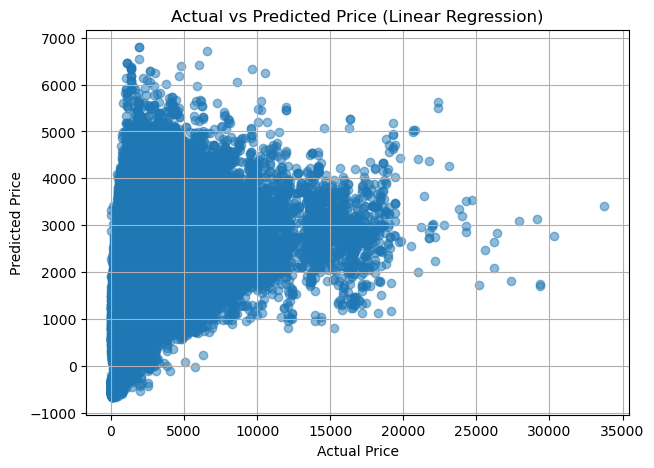

In [17]:
# VISUALISASI
import pandas as pd
import matplotlib.pyplot as plt

pdf = pred.select("price", "prediction").toPandas()
plt.figure(figsize=(7,5))
plt.scatter(pdf["price"], pdf["prediction"], alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (Linear Regression)")
plt.grid()
plt.show()

In [31]:
#RANDOM FOREST
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="price",
    numTrees=30,    # lebih ringan dari 50, tetap akurat
    maxDepth=8,
    seed=42
)
rf_model = rf.fit(train)
print("\n=== Random Forest Model Trained ===")
print("Number of Trees:", rf.getNumTrees())
print("Max Depth:", rf.getOrDefault("maxDepth"))

25/11/27 04:51:04 WARN DAGScheduler: Broadcasting large task binary with size 1178.7 KiB
[Stage 306:======================================>                  (4 + 2) / 6]


=== Random Forest Model Trained ===
Number of Trees: 30
Max Depth: 8


In [32]:
# RANDOM FOREST — PREDIKSI & EVALUASI

pred_rf = rf_model.transform(test)
pred_rf.show(5)
rmse_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "rmse"})
r2_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "r2"})
print("\n=== Random Forest Evaluation ===")
print("RF RMSE:", rmse_rf)
print("RF R2 :", r2_rf)

+------------------+-----+------------------+
|          features|price|        prediction|
+------------------+-----+------------------+
|[55.0,0.0,6.0,5.0]|174.0|239.33355124292441|
|[55.0,0.0,6.0,7.0]|156.0|202.01833329086227|
|[55.0,0.0,7.0,5.0]|560.0| 239.1925292616813|
|[55.0,0.0,8.0,5.0]|190.0|259.33403176125415|
|[55.0,0.0,9.0,5.0]|121.0|259.33403176125415|
+------------------+-----+------------------+
only showing top 5 rows



[Stage 317:===============================================>         (5 + 1) / 6]


=== Random Forest Evaluation ===
RF RMSE: 1692.186094422802
RF R2 : 0.258435627255285


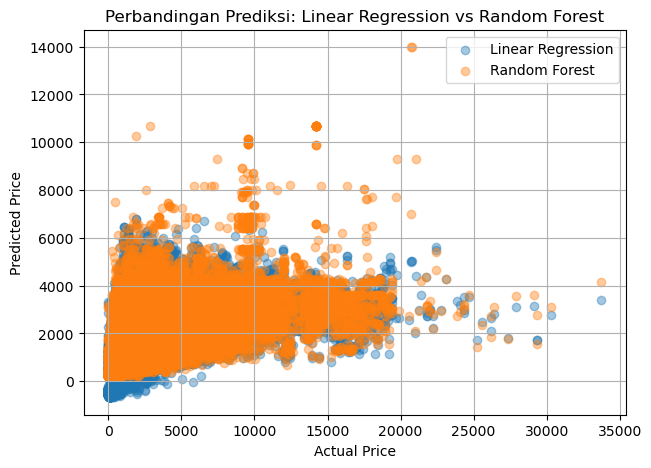

In [33]:
# VISUALISASI MODEL — SCATTER PLOT LR vs RF

pdf_lr = pred.select("price", "prediction").toPandas()
pdf_rf = pred_rf.select("price", "prediction").toPandas()
plt.figure(figsize=(7,5))
plt.scatter(pdf_lr["price"], pdf_lr["prediction"], alpha=0.4, label="Linear Regression")
plt.scatter(pdf_rf["price"], pdf_rf["prediction"], alpha=0.4, label="Random Forest")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Perbandingan Prediksi: Linear Regression vs Random Forest")
plt.grid()
plt.legend()
plt.show()

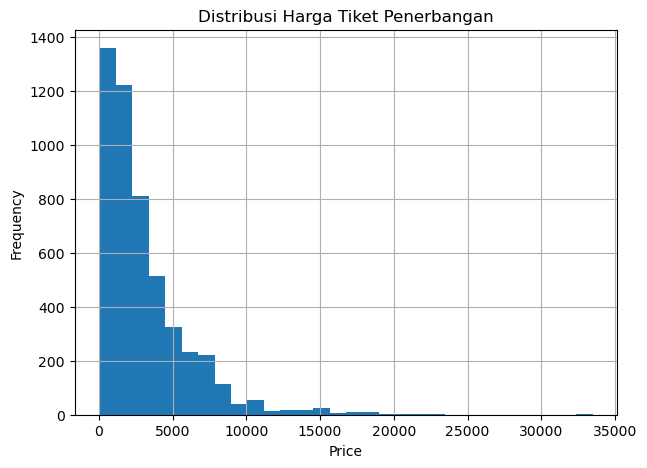

In [34]:
# Histogram Harga Tiket
pdf_full = df.limit(5000).toPandas()

plt.figure(figsize=(7,5))
plt.hist(pdf_full["price"].dropna(), bins=30)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribusi Harga Tiket Penerbangan")
plt.grid()
plt.show()

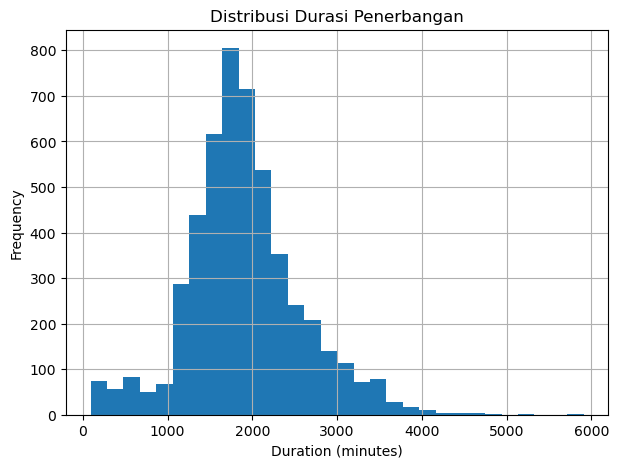

In [35]:
# Histogram Durasi Penerbangan
plt.figure(figsize=(7,5))
plt.hist(pdf_full["duration"].dropna(), bins=30)
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.title("Distribusi Durasi Penerbangan")
plt.grid()
plt.show()

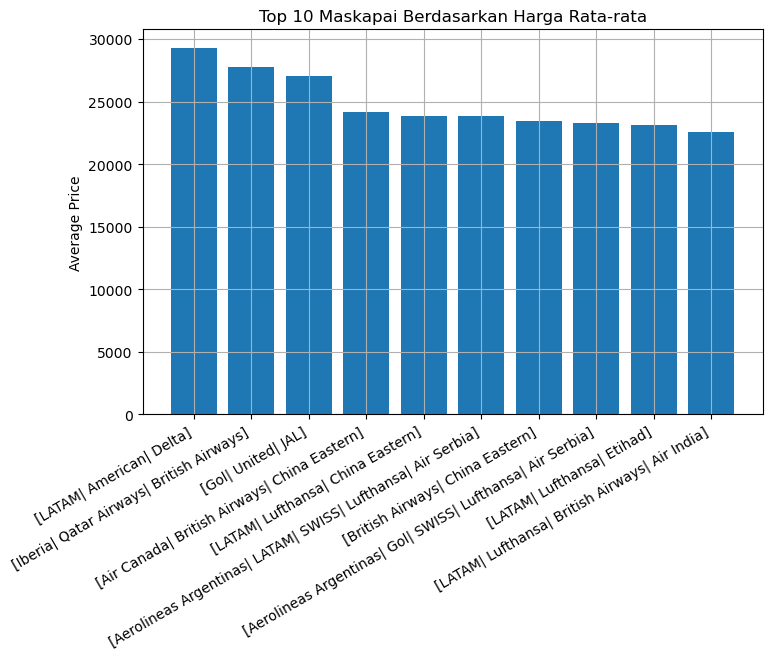

In [36]:
# Bar Chart Rata-rata Harga Maskapai
avg_price_pdf = df.groupBy("airline_name") \
    .agg(F.avg("price").alias("avg_price")) \
    .orderBy(F.desc("avg_price")) \
    .limit(10).toPandas()

plt.figure(figsize=(8,5))
plt.bar(avg_price_pdf["airline_name"], avg_price_pdf["avg_price"])
plt.xticks(rotation=30, ha='right')
plt.ylabel("Average Price")
plt.title("Top 10 Maskapai Berdasarkan Harga Rata-rata")
plt.grid()
plt.show()


<Figure size 1000x600 with 0 Axes>

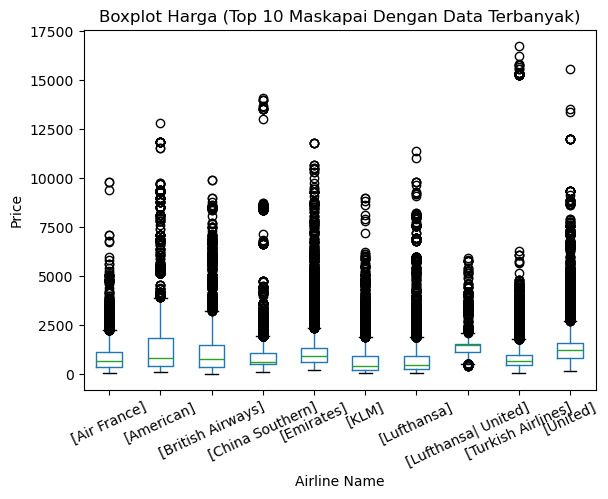

In [37]:
# 10 maskapai dengan data terbanyak
top_airlines = df.groupBy("airline_name") \
    .count() \
    .orderBy(F.desc("count")) \
    .limit(10) \
    .toPandas()["airline_name"].tolist()
box_pdf = df.filter(F.col("airline_name").isin(top_airlines)) \
            .select("airline_name", "price") \
            .toPandas()
plt.figure(figsize=(10,6))
box_pdf.boxplot(column="price", by="airline_name", rot=25)
plt.title("Boxplot Harga (Top 10 Maskapai Dengan Data Terbanyak)")
plt.suptitle("")
plt.xlabel("Airline Name")
plt.ylabel("Price")
plt.grid()
plt.show()

In [38]:
#Penyimpanan hasil akhir
print("=== SELESAI ===")
print("Semua proses ETL → EDA → FE → Modeling → Evaluasi selesai.")

=== SELESAI ===
Semua proses ETL → EDA → FE → Modeling → Evaluasi selesai.
